# Credit Card Fraud Detection

# Introduction

This dataset encompasses credit card transactions made by European cardholders during September 2013. It spans two days, recording 284,807 transactions, of which 492 are fraudulent. This starkly imbalanced dataset, with the positive class (fraudulent transactions) constituting only 0.172% of the total, presents a significant challenge for predictive modeling.

The dataset exclusively comprises numerical input variables derived from a Principal Component Analysis (PCA) transformation. To maintain confidentiality, the original features and detailed background information about the data are not disclosed.

* **Features V1, V2, ..., V28:** These represent the principal components obtained through the PCA transformation.
* **Time:** This feature captures the elapsed seconds between each transaction and the initial transaction within the dataset.
* **Amount:** This feature reflects the transaction amount and can be utilized for example-dependent cost-sensitive learning.
* **Class:** This is the response variable, taking a value of 1 for fraudulent transactions and 0 otherwise.

## Load Packages

In [3]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.graph_objs as go
import plotly.figure_factory as ff 
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

import gc 
from datetime import datetime 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm 
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb

pd.set_option('display.max_columns', 100)

RFC_METRIC = 'gini'  #metric used for RandomForrestClassifier
NUM_ESTIMATORS = 100 #number of estimators used for RandomForrestClassifier
NO_JOBS = 4 #number of parallel jobs used for RandomForrestClassifier


#TRAIN/VALIDATION/TEST SPLIT
#VALIDATION
VALID_SIZE = 0.20 # simple validation using train_test_split
TEST_SIZE = 0.20 # test size using_train_test_split

#CROSS-VALIDATION
NUMBER_KFOLDS = 5 #number of KFolds for cross-validation



RANDOM_STATE = 2018

MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 50 #lgb early stop 
OPT_ROUNDS = 1000  #To be adjusted based on best validation rounds
VERBOSE_EVAL = 50 #Print out metric result

IS_LOCAL = False



## Read the data

In [4]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


let's look into more details to the data

In [5]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,2.239053e-15,1.673327e-15,-1.247012e-15,8.190001e-16,1.207294e-15,4.887456e-15,1.437716e-15,-3.772171e-16,9.564149e-16,1.039917e-15,6.406204e-16,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Looking to the Time feature, we can confirm that the data contains 284,807 transactions, during 2 consecutive days (or 172792 seconds).

## Check missing data

In [6]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending=False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()

,Time,V16,Amount,V28,V27,V26,V25,V24,V23,V22,V21,V20,V19,V18,V17,V15,V1,V14,V13,V12,V11,V10,V9,V8,V7,V6,V5,V4,V3,V2,Class
Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


There is no missing data in the entire dataset.

## Data Unbalance

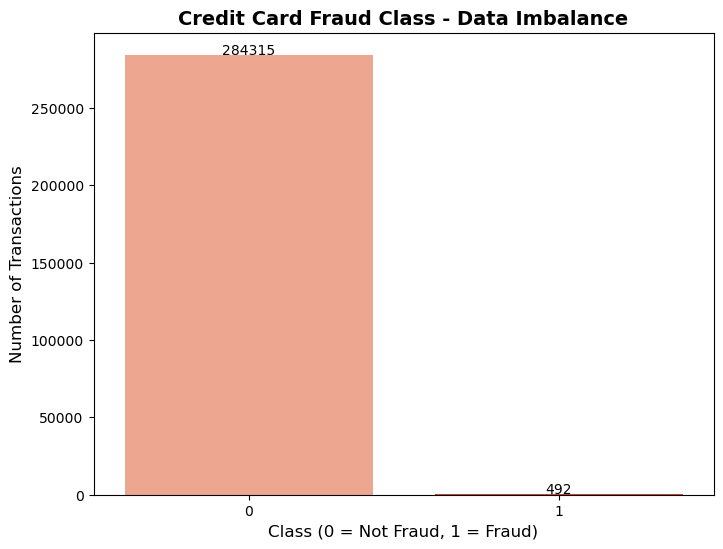

In [7]:

temp = df["Class"].value_counts()
temp_df = pd.DataFrame({'Class': temp.index, 'values': temp.values})


plt.figure(figsize=(8, 6))
sns.barplot(x="Class", y="values", data=temp_df, palette="Reds")

# Adding title and labels
plt.title('Credit Card Fraud Class - Data Imbalance', fontsize=14, weight='bold')
plt.xlabel('Class (0 = Not Fraud, 1 = Fraud)', fontsize=12)
plt.ylabel('Number of Transactions', fontsize=12)

# Adding data labels
for index, row in temp_df.iterrows():
    plt.text(row.name, row['values'] + 50, row['values'], color='black', ha="center", fontsize=10)

plt.show()

Only 492 (or 0.172%) of transaction are fraudulent. That means the data is highly unbalanced with respect with target variable Class.

## Data exploration

Transactions in time

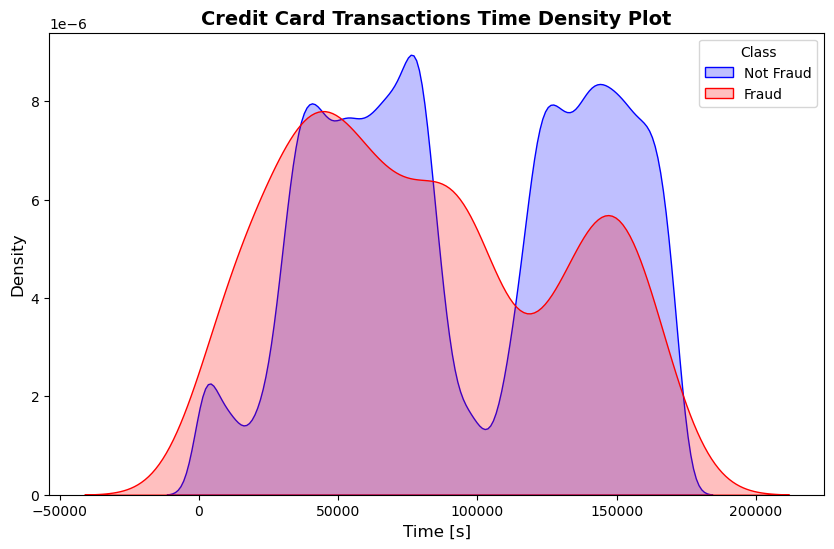

In [8]:
# Extracting time data for both classes
class_0 = df.loc[df['Class'] == 0]["Time"]
class_1 = df.loc[df['Class'] == 1]["Time"]

# Plotting density plots
plt.figure(figsize=(10, 6))
sns.kdeplot(class_0, color='blue', label='Not Fraud', fill=True)
sns.kdeplot(class_1, color='red', label='Fraud', fill=True)

# Adding title and labels
plt.title('Credit Card Transactions Time Density Plot', fontsize=14, weight='bold')
plt.xlabel('Time [s]', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(title="Class")

# Display the plotplt.show()

Fraudulent transactions have a distribution more even than valid transactions - are equaly distributed in time, including the low real transaction times, during night in Europe timezone.


Let's look into more details to the time distribution of both classes transaction, as well as to aggregated values of transaction count and amount, per hour. We assume (based on observation of the time distribution of transactions) that the time unit is second.

In [9]:
df['Hour'] = df['Time'].apply(lambda x: np.floor(x/3600))

tmp = df.groupby(['Hour', 'Class'])['Amount'].agg(['min', 'max', 'count', 'sum', 'mean', 'median', 'var']).reset_index()

tmp_df = pd.DataFrame(tmp)
tmp_df.columns = ['Hour', 'Class', 'Min', 'Max', 'Transactions', 'Sum', 'Mean', 'Median', 'Var']
tmp_df.head()

,Hour,Class,Min,Max,Transactions,Sum,Mean,Median,Var
0,0.0,0,0.0,7712.43,3961,256572.87,64.774772,12.990,45615.821201
1,0.0,1,0.0,529.00,2,529.00,264.500000,264.500,139920.500000
2,1.0,0,0.0,1769.69,2215,145806.76,65.826980,22.820,20053.615770
3,1.0,1,59.0,239.93,2,298.93,149.465000,149.465,16367.832450
4,2.0,0,0.0,4002.88,1555,106989.39,68.803466,17.900,45355.430437


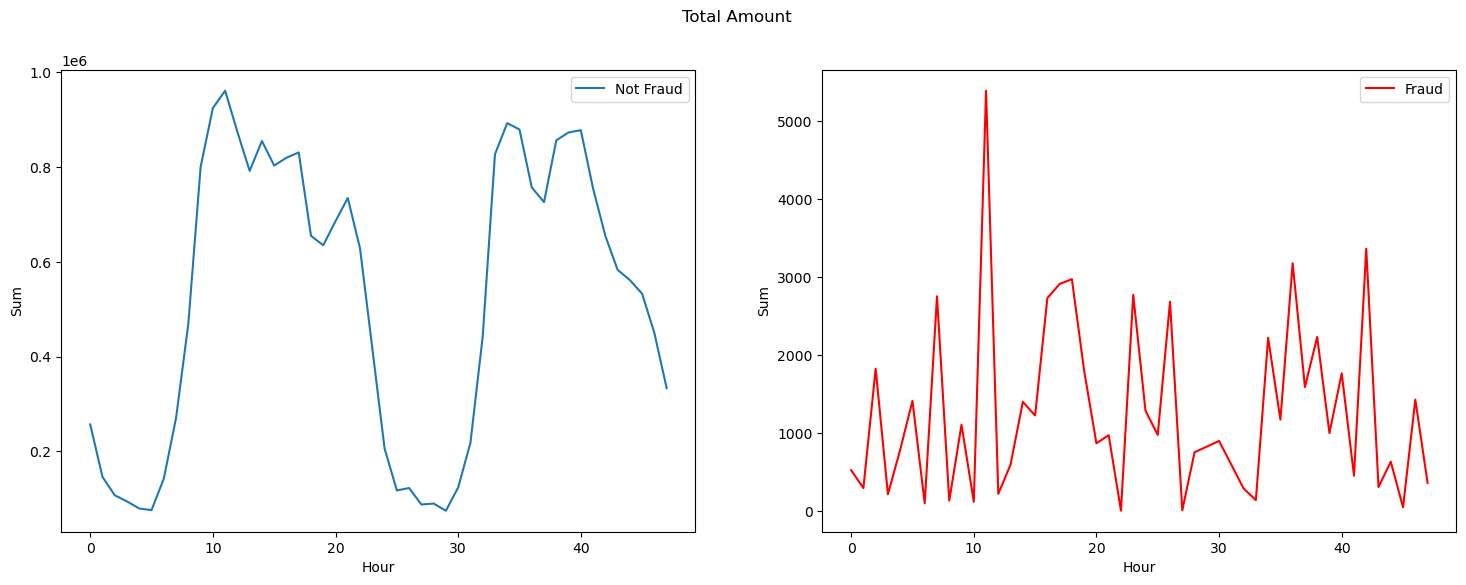

In [10]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Sum", data=tmp_df.loc[tmp_df.Class==0], label='Not Fraud')
s = sns.lineplot(ax = ax2, x="Hour", y="Sum", data=tmp_df.loc[tmp_df.Class==1], color="red", label='Fraud')
plt.suptitle("Total Amount")
plt.legend()
plt.show();

**Interpretation:**

* **Non-Fraud:** Clear pattern with peaks and troughs, suggesting regular spending cycles.
* **Fraud:** Erratic and less structured, with lower and less consistent peaks.

**Overall:** Legitimate transactions show regular patterns in transaction amounts, while fraudulent transactions might be characterized by more irregular and potentially smaller amounts.

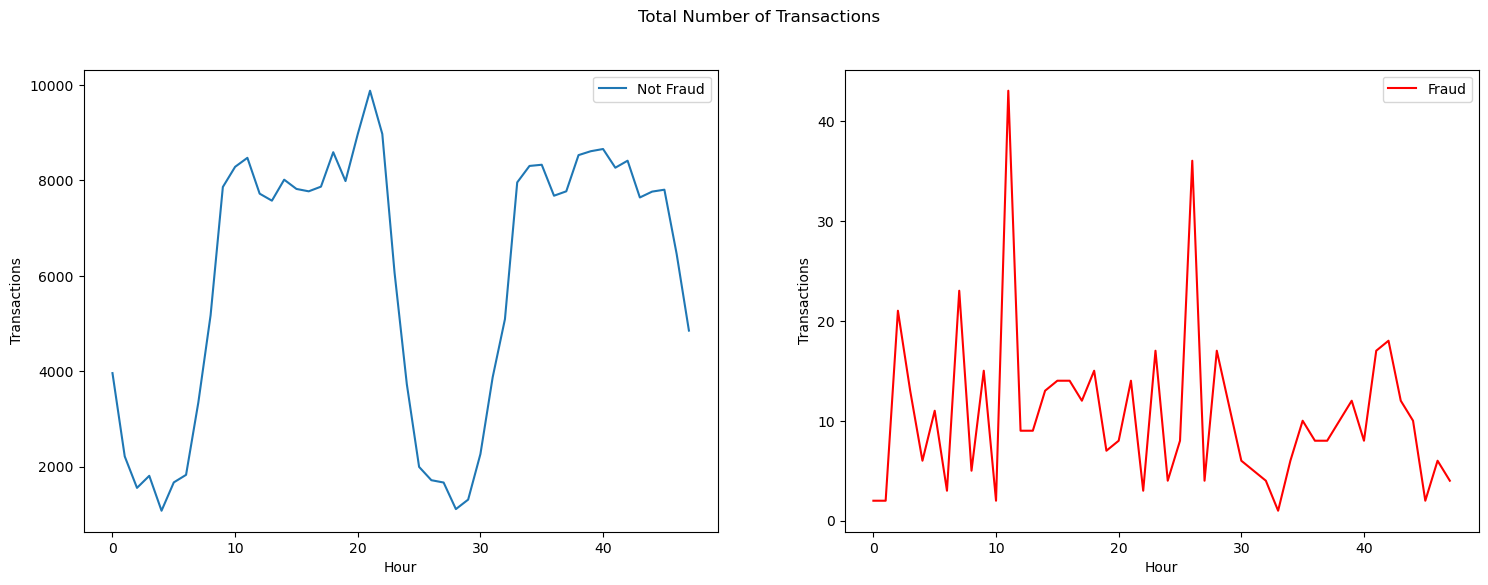

In [11]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Transactions", data=tmp_df.loc[tmp_df.Class==0], label='Not Fraud')
s = sns.lineplot(ax = ax2, x="Hour", y="Transactions", data=tmp_df.loc[tmp_df.Class==1], color="red", label='Fraud')
plt.suptitle("Total Number of Transactions")
plt.show();

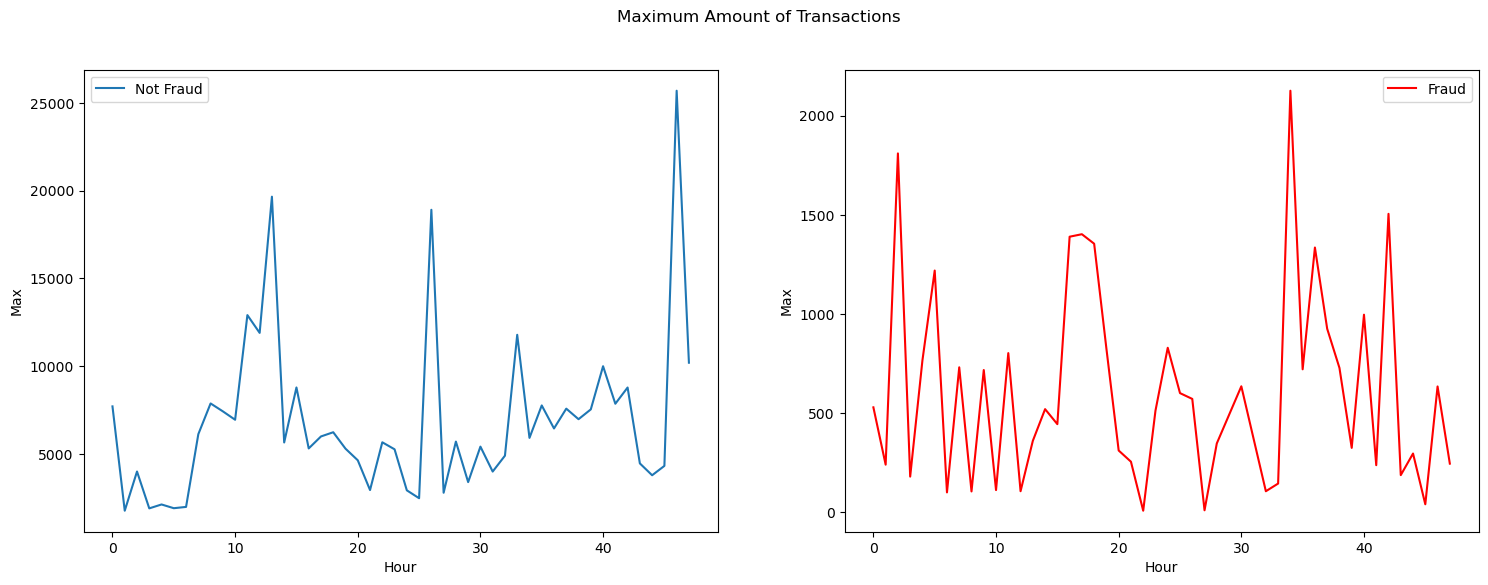

In [12]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Max", data=tmp_df.loc[tmp_df.Class==0], label='Not Fraud')
s = sns.lineplot(ax = ax2, x="Hour", y="Max", data=tmp_df.loc[tmp_df.Class==1], color="red", label='Fraud')
plt.suptitle("Maximum Amount of Transactions")
plt.legend()
plt.show();

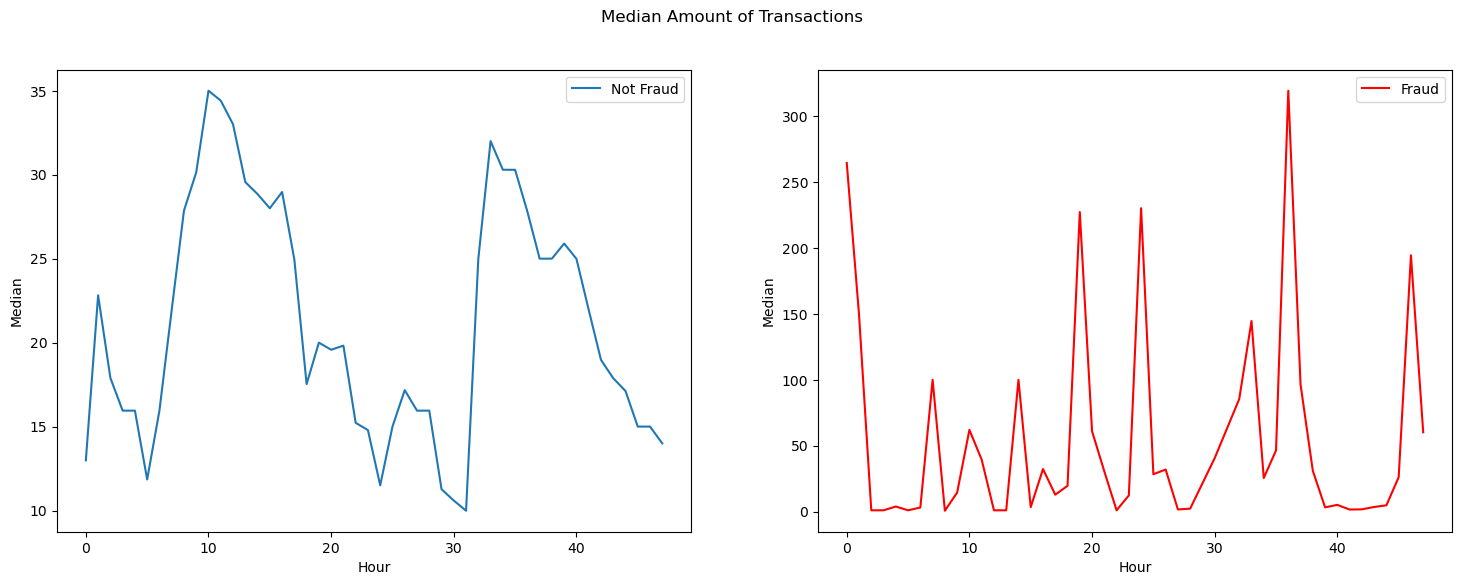

In [13]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Median", data=tmp_df.loc[tmp_df.Class==0], label='Not Fraud')
s = sns.lineplot(ax = ax2, x="Hour", y="Median", data=tmp_df.loc[tmp_df.Class==1], color="red", label='Fraud')
plt.suptitle("Median Amount of Transactions")
plt.legend()
plt.show();

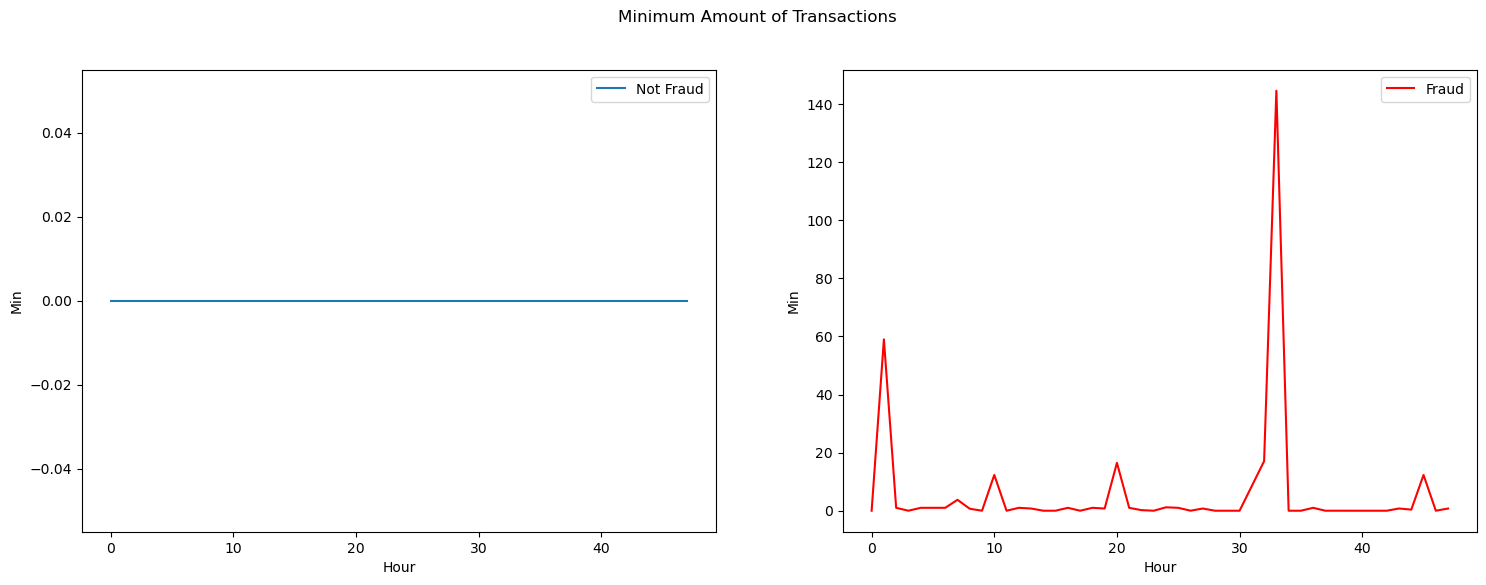

In [14]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Min", data=tmp_df.loc[tmp_df.Class==0], label='Not Fraud')
s = sns.lineplot(ax = ax2, x="Hour", y="Min", data=tmp_df.loc[tmp_df.Class==1], color="red", label='Fraud')
plt.suptitle("Minimum Amount of Transactions")
plt.legend()
plt.show();

**Interpretation:**

* **Non-Fraud:**  The minimum transaction amount for non-fraudulent transactions seems to be consistently low or even zero across all hours. This could indicate that there are a significant number of very small or zero-value transactions in the legitimate category. 

* **Fraud:** The minimum transaction amount for fraudulent transactions shows more variability across hours. There are instances where the minimum amount increases significantly, suggesting that there might be periods where the lower bound for fraudulent transactions is higher.

**Overall:** This visualization suggests that the minimum transaction amount might be a less informative feature for distinguishing between fraudulent and non-fraudulent transactions, especially for the non-fraudulent category where it remains consistently low.

## Transactions amount

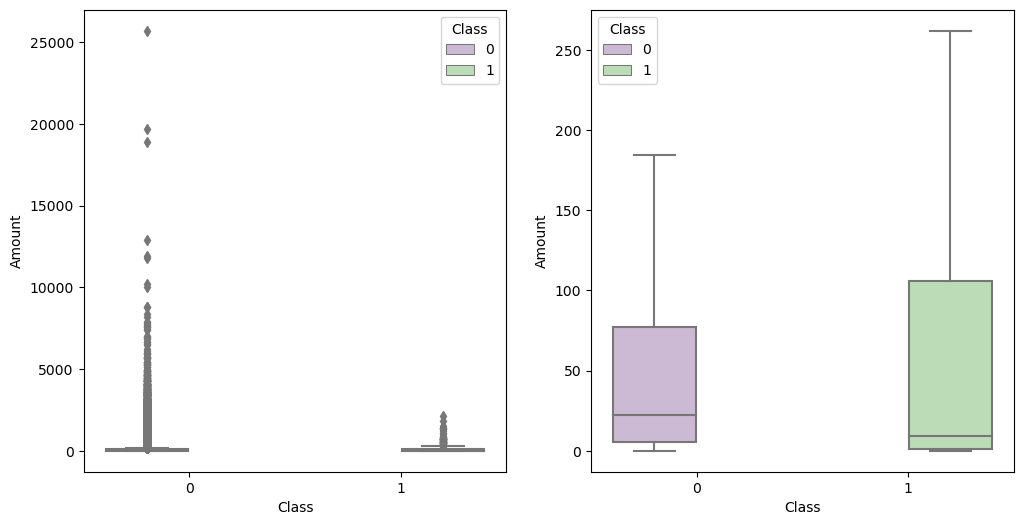

In [15]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
s = sns.boxplot(ax = ax1, x="Class", y="Amount", hue="Class",data=df, palette="PRGn",showfliers=True)
s = sns.boxplot(ax = ax2, x="Class", y="Amount", hue="Class",data=df, palette="PRGn",showfliers=False)
plt.show();

**Interpretation:**

* The box plots show the distribution of transaction amounts for fraudulent and non-fraudulent transactions.
* The median, IQR, and presence of outliers provide insights into the central tendency, spread, and extreme values for each class.
* Overlapping boxes and whiskers indicate potential overlap in the distributions, suggesting that transaction amount alone might not be sufficient to distinguish between fraudulent and non-fraudulent transactions.
* Outliers, especially for fraudulent transactions, might be indicative of unusual or suspicious activities.

In [16]:
tmp = df[['Amount','Class']].copy()
class_0 = tmp.loc[tmp['Class'] == 0]['Amount']
class_1 = tmp.loc[tmp['Class'] == 1]['Amount']
class_0.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [17]:
class_1.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

The real transaction have a larger mean value, larger Q1, smaller Q3 and Q4 and larger outliers; fraudulent transactions have a smaller Q1 and mean, larger Q4 and smaller outliers.

Let's plot the fraudulent transactions (amount) against time. The time is shown is seconds from the start of the time period (totaly 48h, over 2 days).

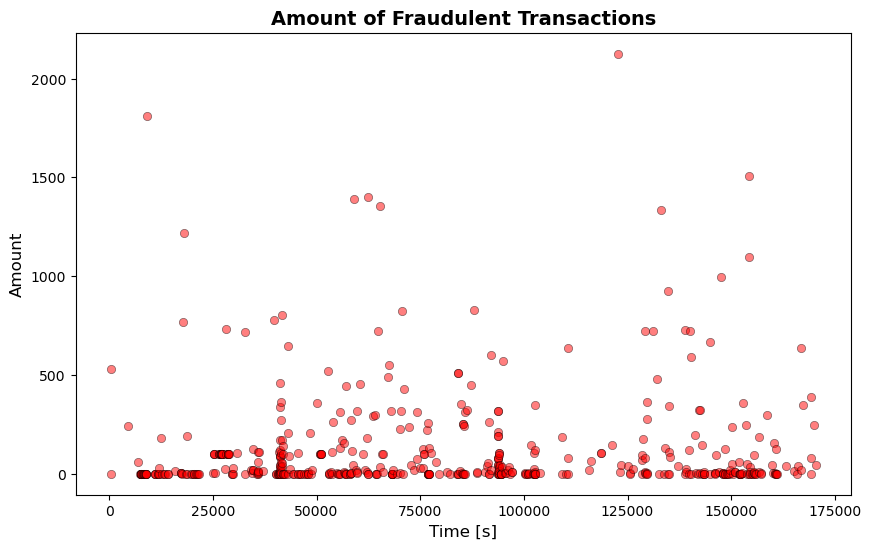

In [18]:
# Filtering fraudulent transactions
fraud = df.loc[df['Class'] == 1]

# Plotting scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(fraud['Time'], fraud['Amount'], color='red', alpha=0.5, edgecolor='black', linewidth=0.5)

# Adding title and labels
plt.title('Amount of Fraudulent Transactions', fontsize=14, weight='bold')
plt.xlabel('Time [s]', fontsize=12)
plt.ylabel('Amount', fontsize=12)

# Display the plot
plt.show()

## Features correlation

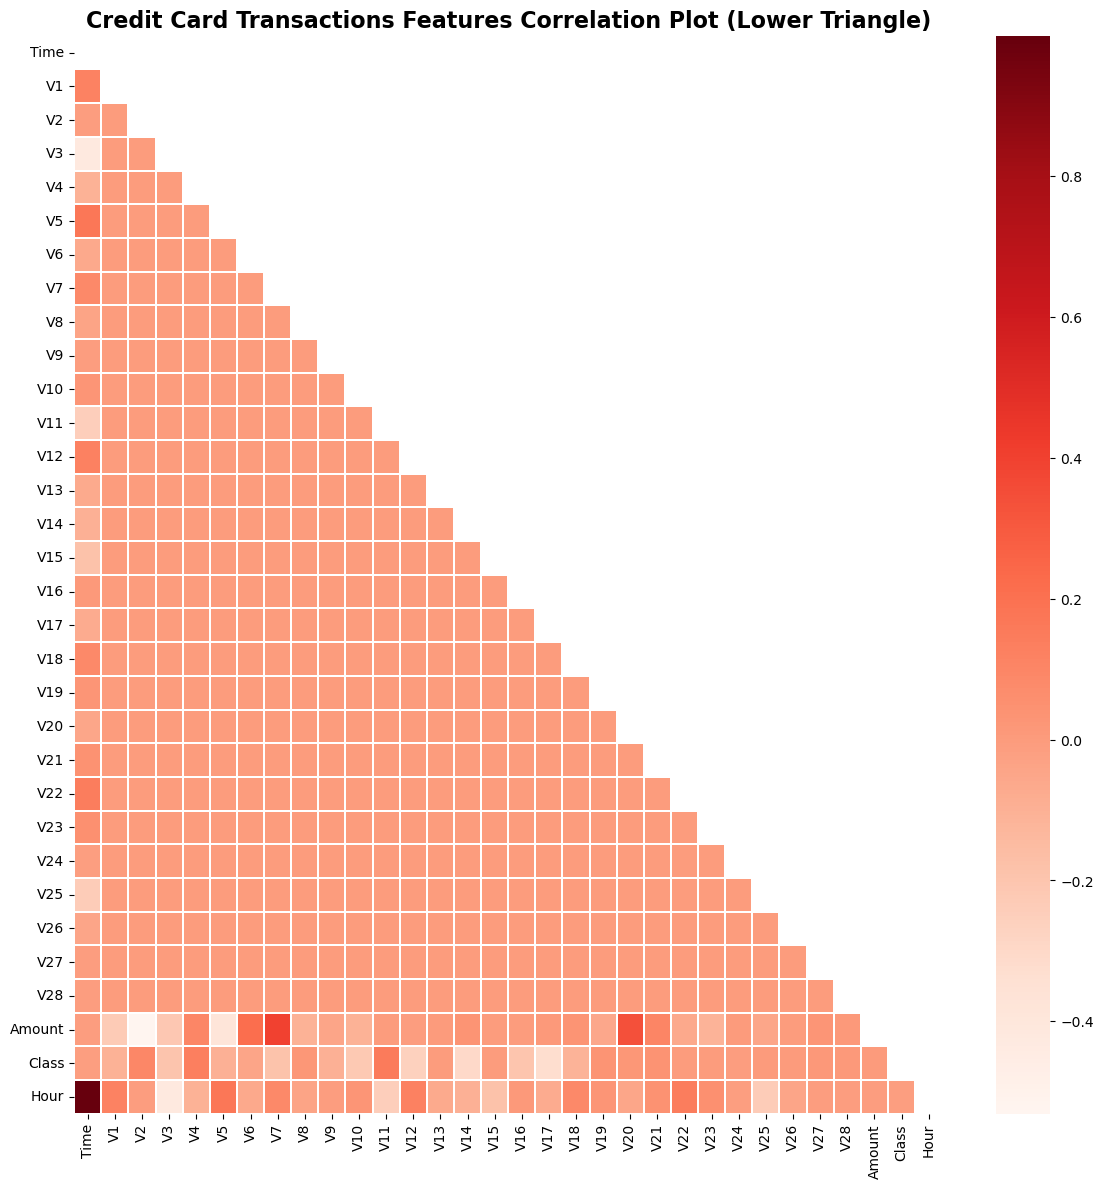

In [19]:
corr = df.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Plot the heatmap with the mask
plt.figure(figsize=(14, 14))
sns.heatmap(corr, mask=mask, cmap="Reds", fmt=".2f", 
            xticklabels=corr.columns, yticklabels=corr.columns, linewidths=0.1)

# Add title
plt.title('Credit Card Transactions Features Correlation Plot (Lower Triangle)', fontsize=16, weight='bold')

# Show plot
plt.show()


As expected, there is no notable correlation between features V1-V28. There are certain correlations between some of these features and Time (inverse correlation with V3) and Amount (direct correlation with V7 and V20, inverse correlation with V1 and V5).

Let's plot the correlated and inverse correlated values on the same graph.

Let's start with the direct correlated values: {V20;Amount} and {V7;Amount}.

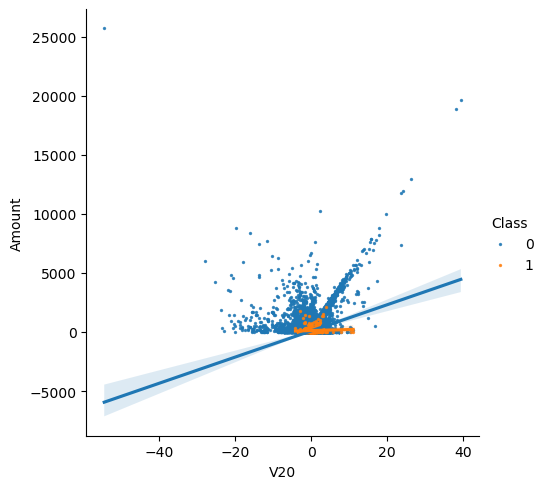

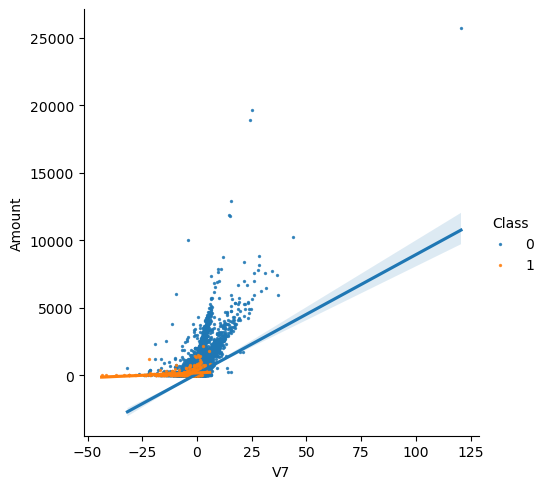

In [20]:
s = sns.lmplot(x='V20', y='Amount',data=df, hue='Class', fit_reg=True,scatter_kws={'s':2})
s = sns.lmplot(x='V7', y='Amount',data=df, hue='Class', fit_reg=True,scatter_kws={'s':2})
plt.show()

We can confirm that the two couples of features are correlated (the regression lines for Class = 0 have a positive slope, whilst the regression line for Class = 1 have a smaller positive slope).

Let's plot now the inverse correlated values.

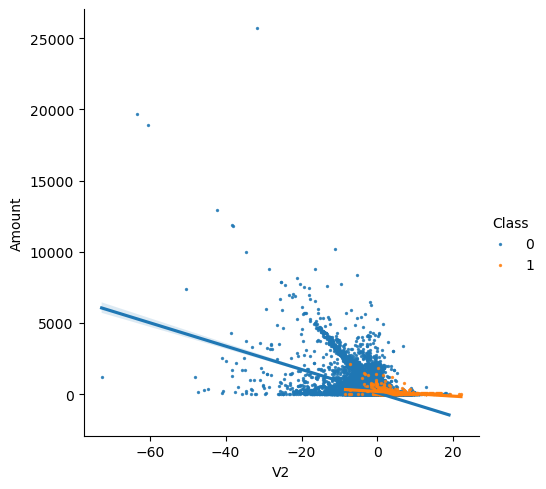

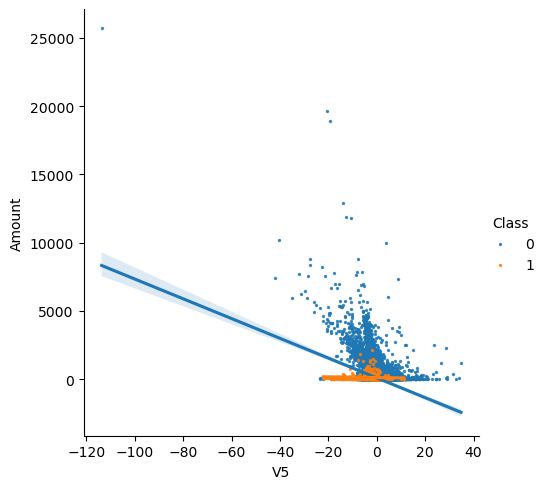

In [21]:
s = sns.lmplot(x='V2', y='Amount',data=df, hue='Class', fit_reg=True,scatter_kws={'s':2})
s = sns.lmplot(x='V5', y='Amount',data=df, hue='Class', fit_reg=True,scatter_kws={'s':2})
plt.show()

We can confirm that the two couples of features are inverse correlated (the regression lines for Class = 0 have a negative slope while the regression lines for Class = 1 have a very small negative slope).

## Features density plot

C:\Users\91965\AppData\Local\Temp\ipykernel_2436\1181212870.py:14: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.

C:\Users\91965\AppData\Local\Temp\ipykernel_2436\1181212870.py:15: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


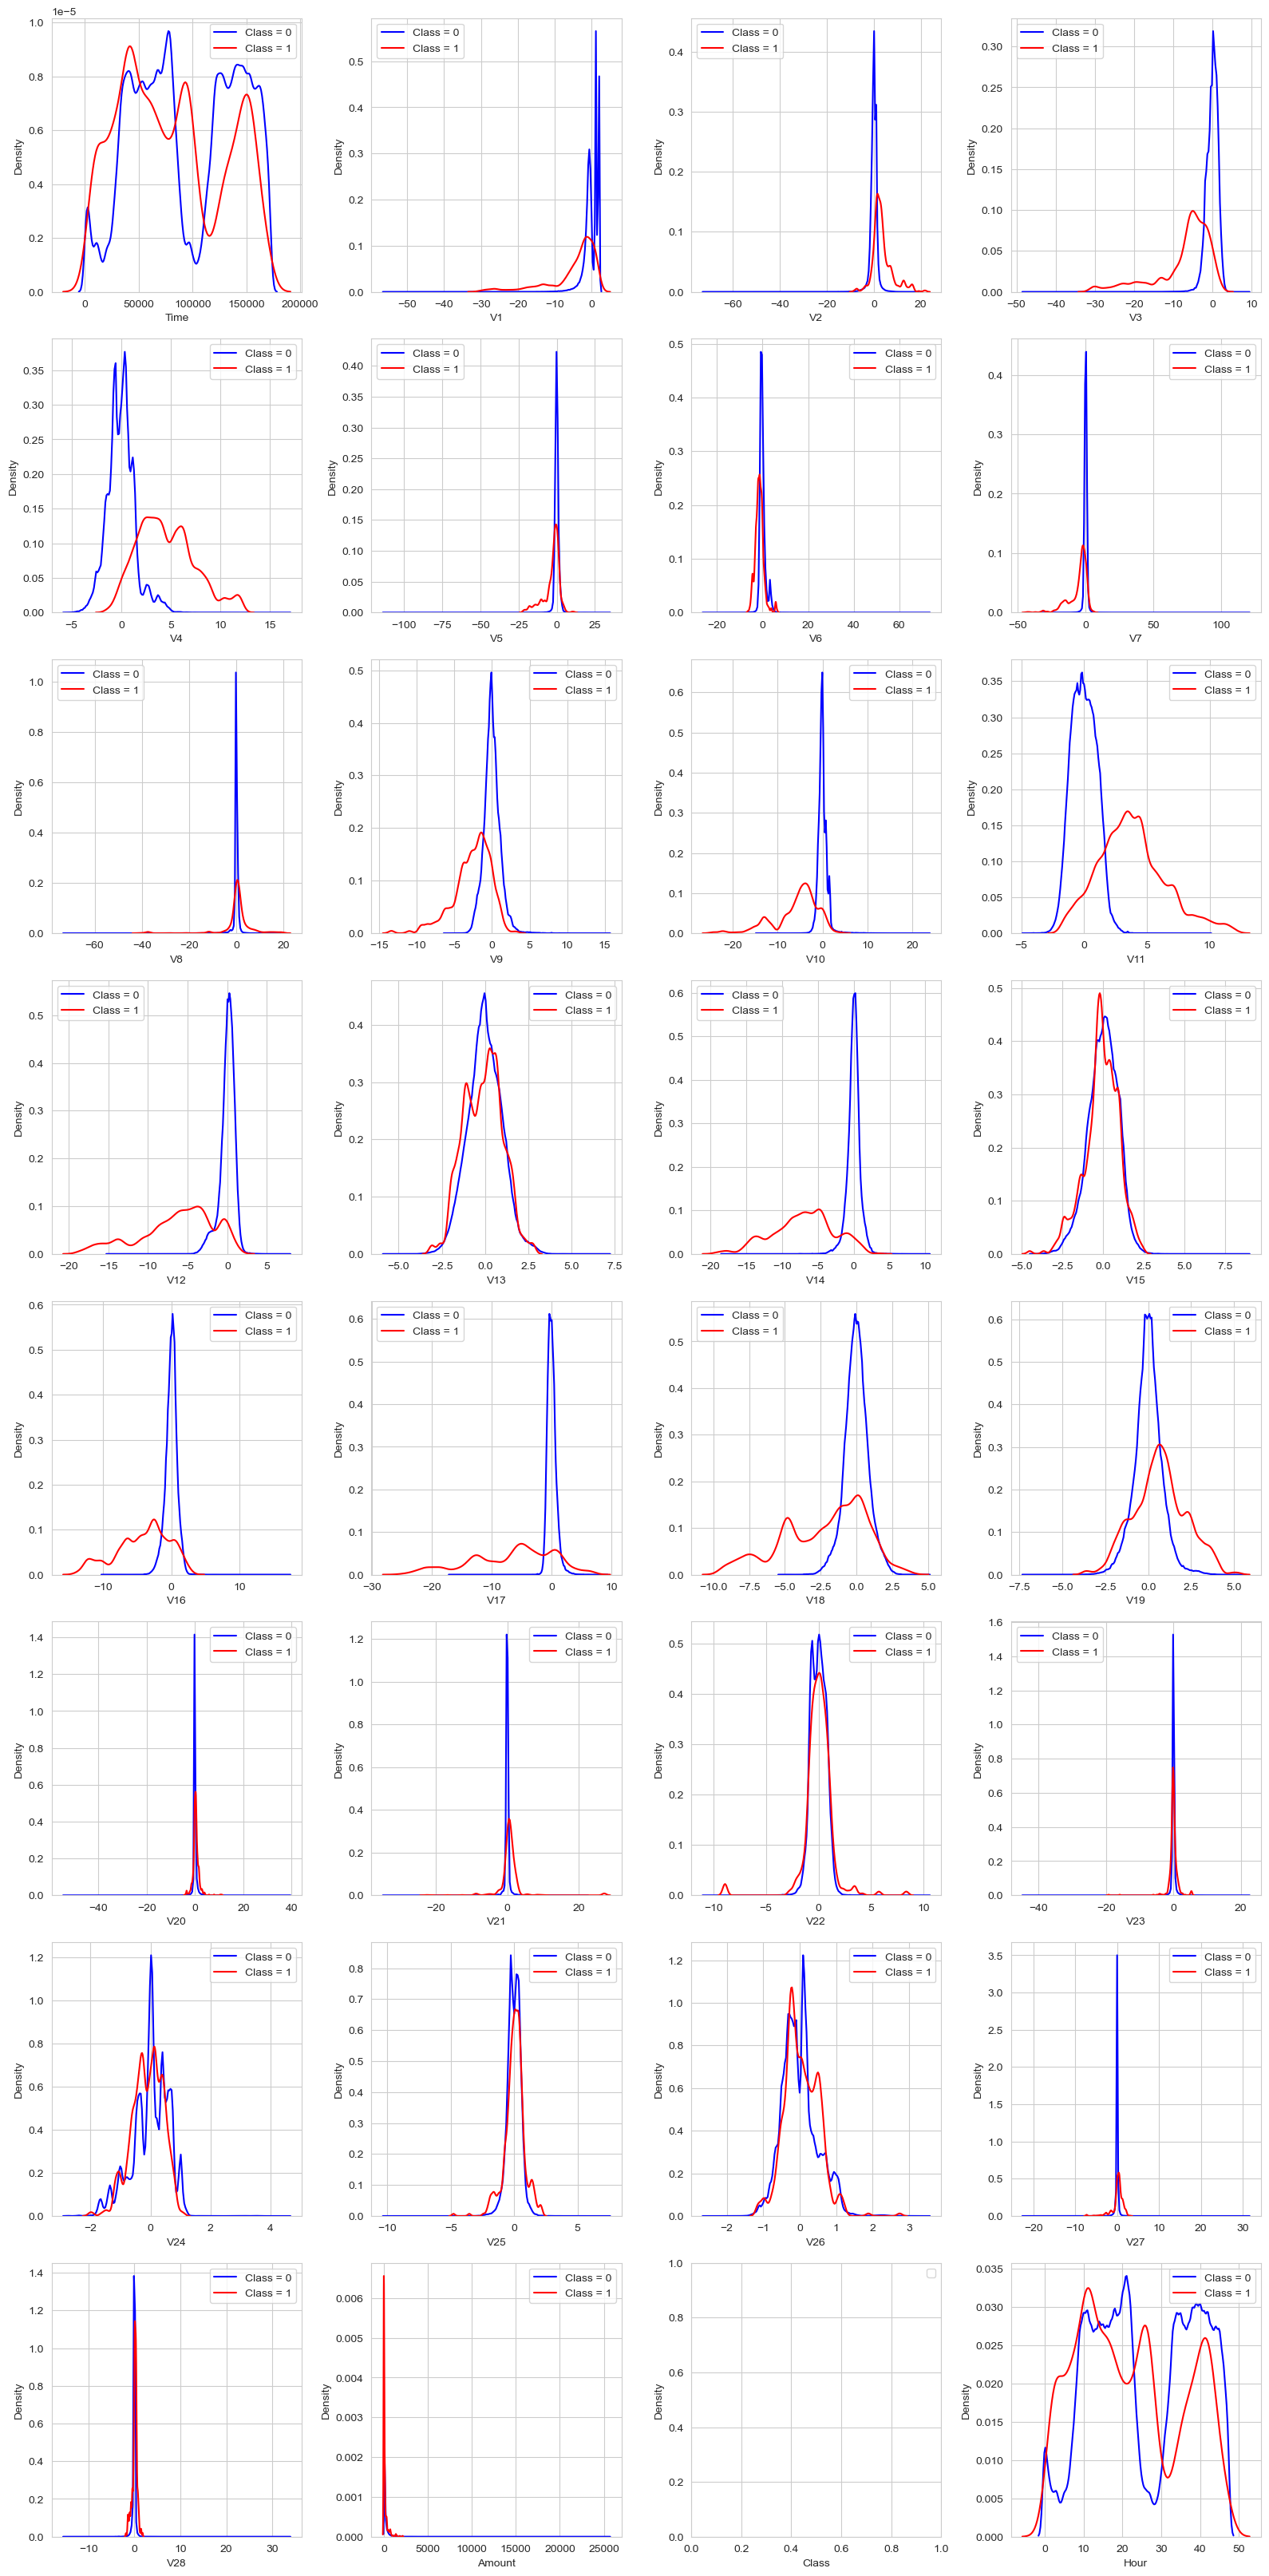

In [22]:
# Extracting class subsets
t0 = df.loc[df['Class'] == 0]
t1 = df.loc[df['Class'] == 1]

# Setting up the grid layout
num_features = len(df.columns)
rows = (num_features // 4) + 1  # Calculate number of rows dynamically
plt.figure(figsize=(16, rows * 4))
sns.set_style('whitegrid')

# Iterating over features and plotting
for i, feature in enumerate(df.columns, start=1):
    plt.subplot(rows, 4, i)
    sns.kdeplot(t0[feature], bw_adjust=0.5, label="Class = 0", color="blue")
    sns.kdeplot(t1[feature], bw_adjust=0.5, label="Class = 1", color="red")
    plt.xlabel(feature, fontsize=10)
    plt.ylabel("Density")
    plt.legend()

# Adjust layout for better display
plt.tight_layout()
plt.show()

**Feature Analysis**

For some of the features, we can observe a good selectivity in terms of distribution for the two values of `Class`:

* **Well-Separated:** `V4`, `V11` have clearly separated distributions for `Class` values 0 and 1. 
* **Partially Separated:** `V12`, `V14`, `V18` are partially separated.
* **Distinct Profile:** `V1`, `V2`, `V3`, `V10` have a quite distinct profile.
* **Similar Profiles:** `V25`, `V26`, `V28` have similar profiles for the two values of `Class`.

In general, with just few exceptions (`Time` and `Amount`), the features distribution for legitimate transactions (`Class = 0`) is centered around 0, sometimes with a long queue at one of the extremities. In the same time, the fraudulent transactions (`Class = 1`) have a skewed (asymmetric) distribution.

## Predictive models

In [95]:
# Helper functions
def plot_confusion_matrix(y_true, y_pred, model_name="Model"):
    """
    Plots the confusion matrix for a given model without grid lines cutting the values.
    
    Parameters:
        y_true (array-like): True labels.
        y_pred (array-like): Predicted labels.
        model_name (str): Name of the model (used for plot title).
    """
    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    # Create display
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Not Fraud', 'Fraud'])
    
    # Plot confusion matrix
    disp.plot(cmap='Blues', values_format='d')
    
    # Remove grid lines
    plt.grid(False)
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()
    
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

def plot_roc_curve(y_true, y_prob, model_name="Model"):
    """
    Plots the ROC curve and prints the ROC AUC score for a given model.
    
    Parameters:
        y_true (array-like): True labels.
        y_prob (array-like): Predicted probabilities for the positive class.
        model_name (str): Name of the model (used for plot title and legend).
    """
    # Compute ROC AUC score
    roc_auc = roc_auc_score(y_true, y_prob)
    print(f"ROC AUC Score: {roc_auc:.2f}")
    
    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    
    # Plot the ROC curve
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})", color='darkorange')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.show()


**Define predictors and target values**

Let's define the predictor features and the target features. Categorical features, if any, are also defined. In our case, there are no categorical feature

In [23]:
target = 'Class'
predictors = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',\
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',\
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',\
       'Amount']

**Split data in train, test and validation set**

Let's define train, validation and test sets.

In [24]:
train_df, test_df = train_test_split(df, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True )
train_df, valid_df = train_test_split(train_df, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True )

Let's start with a Logistic Regression model.

## LogisticRegression

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve


### Step 1: Initialize and train the Logistic Regression model

In [26]:
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(train_df[predictors], train_df[target].values)

LogisticRegression(max_iter=1000, random_state=42)

### Step 2: Make predictions on the validation set

In [27]:
y_valid_pred = log_reg.predict(valid_df[predictors])
y_valid_prob = log_reg.predict_proba(valid_df[predictors])[:, 1]  # Probability scores for ROC

### Step 3: Evaluate the confusion matrix

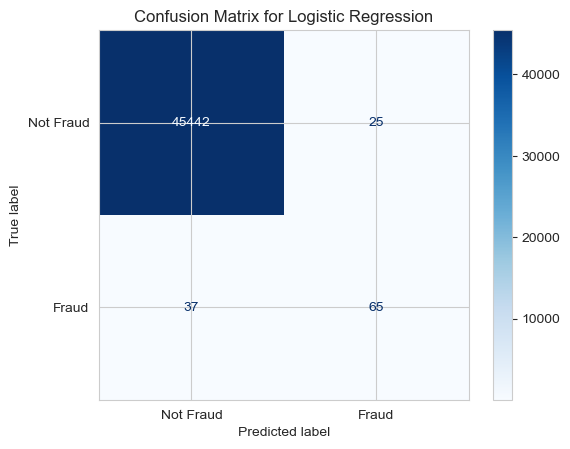

In [28]:
plot_confusion_matrix(valid_df[target].values, y_valid_pred, 'Logistic Regression')

**Type I and Type II Errors**

Confusion matrices are not a very good tool to represent the results in the case of largely unbalanced data. We need a different metric that accounts for both selectivity and specificity of the method, minimizing both Type I and Type II errors.

**Hypotheses:**

* **Null Hypothesis (H0):** The transaction is not a fraud.
* **Alternative Hypothesis (H1):** The transaction is a fraud.

**Error Types:**

* **Type I Error:** Rejecting H0 when H0 is true (False Positive).
    * Cost: Erroneously flagging a legitimate transaction as fraudulent.
* **Type II Error:** Failing to reject H0 when H1 is true (False Negative).
    * Cost: Erroneously allowing a fraudulent transaction to go through.

In [29]:
conf_matrix

array([[45442,    25],
       [   37,    65]], dtype=int64)

### Step 4: Compute and display ROC AUC score

In [30]:
roc_auc = roc_auc_score(valid_df[target].values, y_valid_prob)
print(f"ROC AUC Score: {roc_auc:.2f}")

ROC AUC Score: 0.85


### Step 5: Plot ROC Curve

ROC AUC Score: 0.85


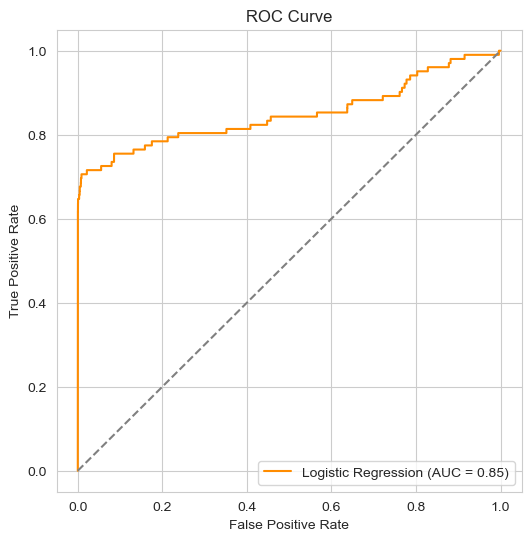

In [96]:
plot_roc_curve(valid_df[target], y_valid_prob, model_name="Logistic Regression")

# Logistic Regression Model: Evaluation and Next Steps

### 1. Logistic Regression Model Training
We began by training a **Logistic Regression** model on the credit card fraud detection dataset. Logistic regression is a linear classifier that predicts the probability of a binary outcome (fraud or not fraud in this case). We evaluated the model using the following steps:

- **Confusion Matrix:**
  We computed the confusion matrix to identify the number of correct and incorrect predictions made by the model. The confusion matrix helps us understand the **Type I (False Positive)** and **Type II (False Negative)** errors:
  - **True Negatives (TN)**: 45442 transactions correctly identified as not fraud.
  - **False Positives (FP)**: 25 transactions incorrectly predicted as fraud (Type I error).
  - **False Negatives (FN)**: 37 transactions incorrectly predicted as not fraud (Type II error).
  - **True Positives (TP)**: 65 transactions correctly predicted as fraud.

- **ROC AUC Score:**
  The **ROC AUC score** was calculated, which tells us how well the model distinguishes between the classes (fraud and non-fraud). Our **ROC AUC score was 0.85**, meaning the model has a good ability to differentiate between the two classes. A score closer to 1 indicates better performance.



### 2. Next Steps: Hyperparameter Tuning for Logistic Regression

Now that we have the baseline performance of the logistic regression model, we will attempt to improve its performance by fine-tuning its hyperparameters. Hyperparameter tuning will help us optimize parameters such as:
- **Regularization strength (C)**: Controls the level of regularization (penalty) applied to the model.
- **Solver choice**: Different solvers can impact optimization speed and accuracy.
- **Penalty type**: We will experiment with L1 (Lasso) regularization.

We will use **GridSearchCV** to find the optimal hyperparameters by exhaustively searching over a specified hyperparameter grid and evaluating the model using **cross-validation**.

In [32]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear'],
    'penalty': ['l1']
}

grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='roc_auc')
grid_search.fit(train_df[predictors], train_df[target].values)
best_model = grid_search.best_estimator_


In [33]:
best_model

LogisticRegression(C=0.1, penalty='l1', solver='liblinear')

In [34]:
# Make predictions on the validation set
y_pred = best_model.predict(valid_df[predictors])  
y_prob = best_model.predict_proba(valid_df[predictors])[:, 1]  # Get probabilities for the positive class (fraud)

# Compute confusion matrix
cm = confusion_matrix(valid_df[target].values, y_pred)
print("Confusion Matrix:")
print(cm)




Confusion Matrix:
[[45461     6]
 [   42    60]]


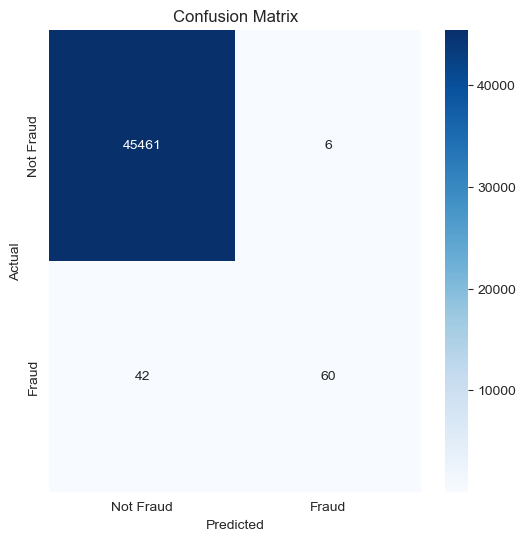

In [35]:
plot_confusion_matrix(valid_df[target].values, y_pred, 'Tuned Logistic Regression')


ROC AUC Score: 0.98


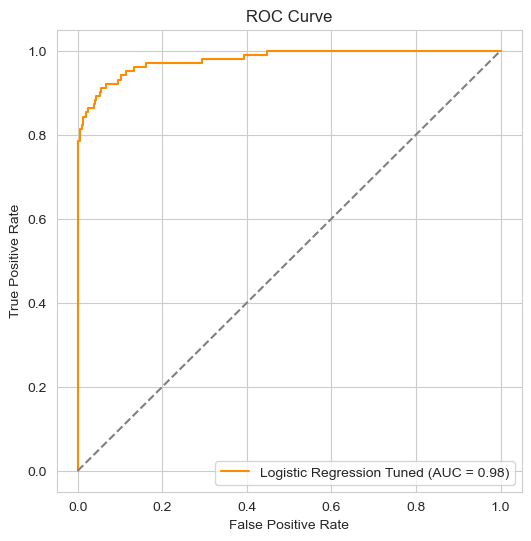

In [98]:
plot_roc_curve(valid_df[target].values, y_prob, model_name="Logistic Regression Tuned")

### Model Evaluation: Logistic Regression (With Hyperparameter Tuning)

We have successfully trained a Logistic Regression model with hyperparameter tuning using GridSearchCV. After evaluating the model using a **Confusion Matrix** and **ROC AUC Score**, we observed the following results:

- **True Negatives (TN)**: 45,461 - Correctly predicted non-fraudulent transactions.
- **False Positives (FP)**: 6 - Incorrectly predicted non-fraudulent transactions as fraudulent (Type I Error).
- **False Negatives (FN)**: 42 - Incorrectly predicted fraudulent transactions as non-fraudulent (Type II Error).
- **True Positives (TP)**: 60 - Correctly predicted fraudulent transactions.

The confusion matrix shows that the model is performing well, with very few false positives and false negatives, which is important for fraud detection.

#### ROC AUC Score:
- **ROC AUC Score**: 0.98
  - The AUC score of 0.98 indicates that the model is highly effective in distinguishing between fraud and non-fraud transactions, with a near-perfect classification ability.

### Conclusion:
- The model has achieved high performance with very few errors, as indicated by the low number of false positives and false negatives.
- The ROC AUC score of 0.98 further confirms the model's excellent ability to discriminate between fraudulent and non-fraudulent transactions.
  
### Next Steps:
- We will now proceed to test and evaluate additional models, such as **Decision Trees**, **Voting Classifiers**, and **Ensemble Methods** (Bagging and Boosting), as part of our goal to experiment with multiple predictors and fine-tune their performance.



## Decision Trees


### Step 1: Initialize and train the Decision Tree Classifier model

In [37]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report

# Initialize the model
dt_model = DecisionTreeClassifier(random_state=42)

# Train the model
dt_model.fit(train_df[predictors], train_df[target])

DecisionTreeClassifier(random_state=42)

### Step 2: Make predictions on the validation set

In [38]:
dt_preds = dt_model.predict(valid_df[predictors])

### Step 3: Evaluate the confusion matrix

In [39]:
cm = confusion_matrix(valid_df[target], dt_preds)


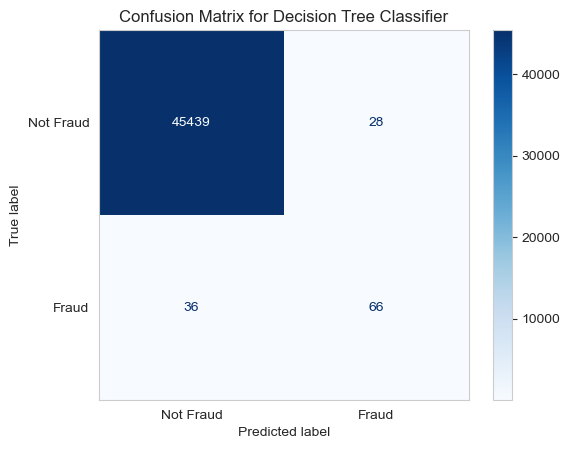

In [99]:
plot_confusion_matrix(valid_df[target].values, dt_preds, 'Decision Tree Classifier')

In [41]:
cm

array([[45439,    28],
       [   36,    66]], dtype=int64)

### Step 4: Compute and display ROC AUC score

In [42]:
roc_auc = roc_auc_score(valid_df[target], dt_model.predict_proba(valid_df[predictors])[:, 1])
print("\nROC AUC Score:", roc_auc)


ROC AUC Score: 0.8232214961335887


### Step 5: Plot ROC Curve

ROC AUC Score: 0.82


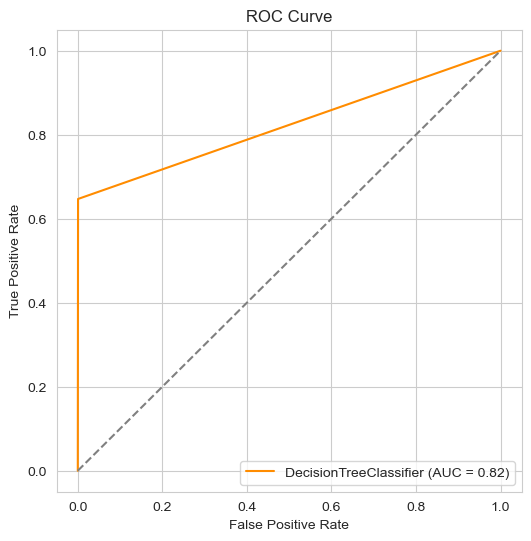

In [104]:
plot_roc_curve(valid_df[target], dt_model.predict_proba(valid_df[predictors])[:, 1], model_name="DecisionTreeClassifier")

# Decision Tree Classifier Evaluation

## Model Evaluation

After training and testing the **Decision Tree Classifier**, we evaluate the model using the following metrics:

### 1. **Confusion Matrix**:
The confusion matrix for the model's performance on the validation set is as follows:

[[45439, 28],
 [ 36, 66]]

- **True Negatives (TN)**: 45439 – Correctly classified non-fraudulent transactions.
- **False Positives (FP)**: 28 – Non-fraudulent transactions wrongly classified as fraudulent.
- **False Negatives (FN)**: 36 – Fraudulent transactions wrongly classified as non-fraudulent.
- **True Positives (TP)**: 66 – Correctly classified fraudulent transactions.

### 2. **ROC AUC Score**:
The **ROC AUC Score** is **0.8232**. This indicates a **good** ability of the model to differentiate between fraudulent and non-fraudulent transactions. However, there's room for improvement in distinguishing these classes more clearly.

### 3. **Key Observations**:
- The **False Positive Rate** (FP) is relatively low, meaning there are not too many non-fraudulent transactions flagged as fraud.
- The **False Negative Rate** (FN) is also reasonably low, but it should be kept in mind that we are missing some fraudulent transactions.


## Random Forest Classifier

### Step 1: Initialize and train the Random Forest Classifier model

In [44]:
from sklearn.ensemble import RandomForestClassifier

# Train the model
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(train_df[predictors], train_df[target])

RandomForestClassifier(random_state=42)

### Step 2: Make predictions on the validation set

In [45]:
# Evaluate on validation set
rf_preds = rf_model.predict(valid_df[predictors])

### Step 3: Evaluate the confusion matrix

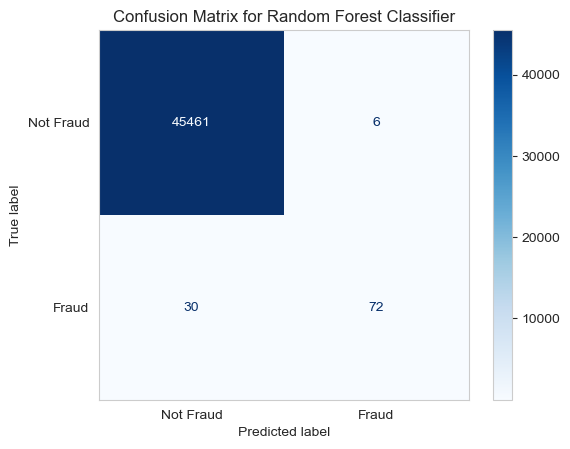

In [105]:
plot_confusion_matrix(valid_df[target].values, rf_preds, 'Random Forest Classifier')

### Step 4: Compute and display ROC AUC score

In [47]:
rf_roc_auc = roc_auc_score(valid_df[target], rf_model.predict_proba(valid_df[predictors])[:, 1])
print("\nROC AUC Score:", rf_roc_auc)


ROC AUC Score: 0.909562720990919


### Step 5: Plot ROC Curve

ROC AUC Score: 0.91


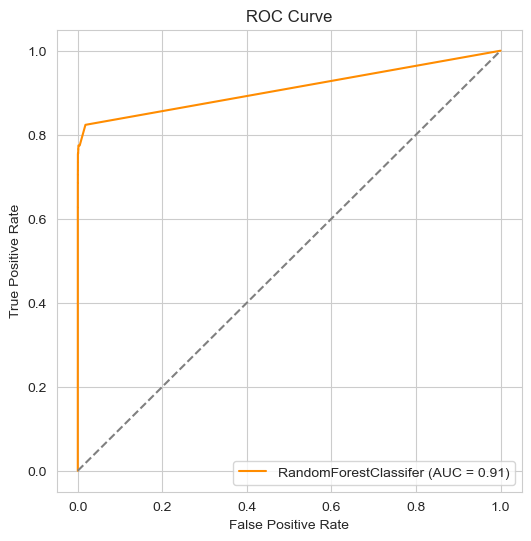

In [106]:
plot_roc_curve(valid_df[target], rf_model.predict_proba(valid_df[predictors])[:, 1], model_name="RandomForestClassifer")

#### let's also visualize feature importance

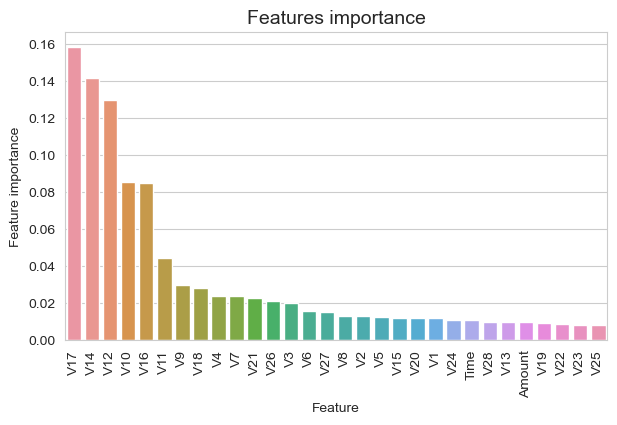

In [107]:
target = 'Class'
predictors = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',\
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',\
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',\
       'Amount']
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': rf_model.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()  


### Random Forest Classifier Performance

The Random Forest Classifier demonstrated strong performance with an ROC AUC Score of **0.91**, indicating effective handling of class imbalance and good predictive power.

---

### Next Step: K-Nearest Neighbors (KNN) Classifier

The KNN Classifier will be implemented as the next step. It is a simple algorithm that classifies based on the majority vote of its neighbors, and it will contribute to the diversity of the Voting Classifier.


### Step 1: Initialize and train the K-Nearest Classifier model

In [108]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(train_df[predictors], train_df[target])


KNeighborsClassifier()

### Step 2: Make predictions on the validation set

In [ ]:
# Evaluate on validation set
knn_preds = knn_model.predict(valid_df[predictors])


### Step 3: Evaluate the confusion matrix

Confusion Matrix:
[[45467     0]
 [   99     3]]


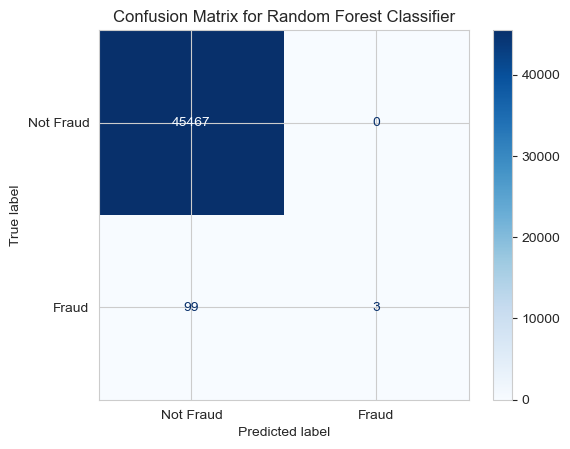

In [52]:
plot_confusion_matrix(valid_df[target].values, knn_preds, 'K Nearest Classifier')

### Step 4: Compute and display ROC AUC score

In [53]:
knn_roc_auc = roc_auc_score(valid_df[target], knn_model.predict_proba(valid_df[predictors])[:, 1])
print("\nROC AUC Score:", knn_roc_auc)


ROC AUC Score: 0.5820057167081318


### Step 5: Plot ROC Curve

ROC AUC Score: 0.58


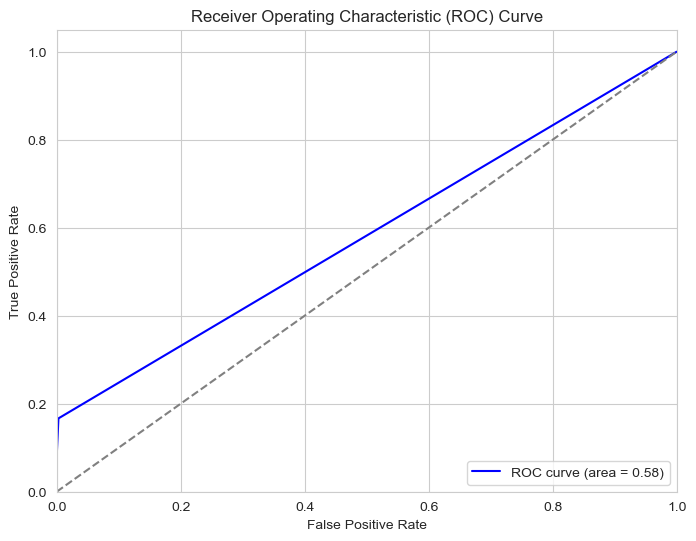

In [54]:
# Compute ROC AUC Score
roc_auc = roc_auc_score(valid_df[target].values, knn_model.predict_proba(valid_df[predictors])[:, 1])
print(f'ROC AUC Score: {roc_auc:.2f}')

# Optional: Plot ROC curve for visualization
fpr, tpr, thresholds = roc_curve(valid_df[target].values, knn_model.predict_proba(valid_df[predictors])[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### K-Nearest Neighbors (KNN) Classifier Performance

The KNN Classifier showed limited performance with an ROC AUC Score of **0.58**, suggesting it may not effectively handle this dataset's complexities or class imbalance. However, its simplicity and diverse prediction approach make it a valuable component for ensemble methods.

---

### Next Step: Naive Bayes Classifier

The Naive Bayes Classifier will be implemented next. Despite its assumption of feature independence, it can perform well on certain datasets and will add diversity to the Voting Classifier.


### Step 1: Initialize and train the Naive-Bayes Classifier model


In [55]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, roc_auc_score

# Initialize the Naive Bayes model
nb_model = GaussianNB()
# Train the model
nb_model.fit(train_df[predictors], train_df[target])

GaussianNB()

### Step 2: Make predictions on the validation set


In [56]:
# Predict on validation data
nb_preds = nb_model.predict(valid_df[predictors])

### Step 3: Evaluate the confusion matrix

Confusion Matrix:
[[45209   258]
 [   38    64]]


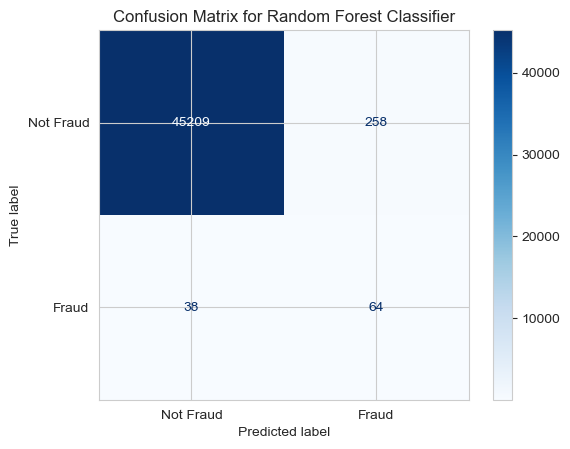

In [57]:
plot_confusion_matrix(valid_df[target].values, nb_preds, 'Naive Bayes Classifier')

### Step 4: Compute and display ROC AUC score

In [58]:
nb_roc_auc = roc_auc_score(valid_df[target], nb_model.predict_proba(valid_df[predictors])[:, 1]) 
print("\nROC AUC Score:", nb_roc_auc)


ROC AUC Score: 0.9618447682589872


### Step 5: Plot ROC Curve

ROC AUC Score: 0.96


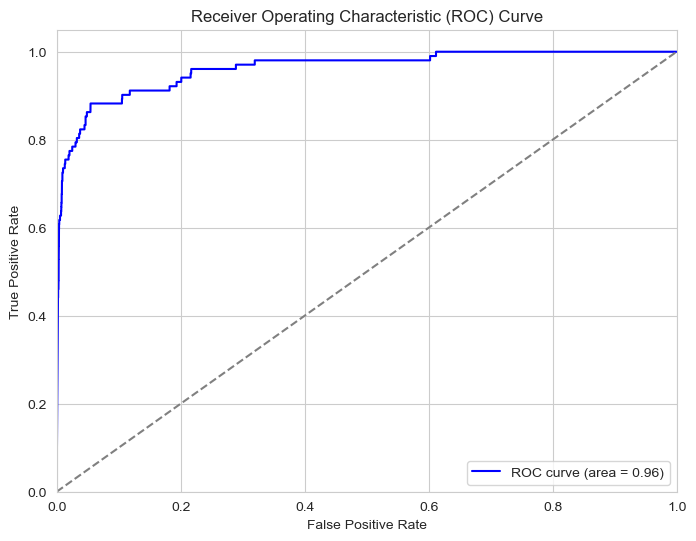

In [59]:
# Compute ROC AUC Score
roc_auc = roc_auc_score(valid_df[target].values, nb_model.predict_proba(valid_df[predictors])[:, 1])
print(f'ROC AUC Score: {roc_auc:.2f}')

# Optional: Plot ROC curve for visualization
fpr, tpr, thresholds = roc_curve(valid_df[target].values, nb_model.predict_proba(valid_df[predictors])[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Naive Bayes Classifier

The Naive Bayes classifier was applied to detect fraudulent transactions. It achieved a **ROC AUC Score of 0.96**, indicating excellent performance in distinguishing between fraud and non-fraud transactions. While the confusion matrix highlighted some misclassifications, the model demonstrated strong predictive power for fraud detection.

This model's simplicity and effectiveness make it a valuable addition to our exploration of classifiers. 


## Building a Voting Classifier

We are now moving forward to build a **Voting Classifier** by combining the following trained models:

- Logistic Regression
- Decision Tree
- Random Forest
- K-Nearest Neighbors (KNN)
- Naive Bayes

This ensemble approach will leverage the strengths of each individual model to improve overall classification performance. Both **hard voting** and **soft voting** techniques will be explored to evaluate their effectiveness in detecting fraudulent transactions.


### Step 1: Initialize and train the Voting Classifier model using hard voting


In [60]:
from sklearn.ensemble import VotingClassifier

In [61]:
voting_clf_hard = VotingClassifier(estimators=[
    ('logreg', best_model), 
    ('dt', dt_model), 
    ('rf', rf_model), 
    ('knn', knn_model), 
    ('nb', nb_model)
], voting='hard',
   verbose = 1)

In [62]:
# Train the models on the training set
voting_clf_hard.fit(train_df[predictors], train_df[target])


[Voting] ................... (1 of 5) Processing logreg, total=   4.6s
[Voting] ....................... (2 of 5) Processing dt, total=  40.7s
[Voting] ....................... (3 of 5) Processing rf, total= 8.7min
[Voting] ...................... (4 of 5) Processing knn, total=   0.2s
[Voting] ....................... (5 of 5) Processing nb, total=   0.3s


VotingClassifier(estimators=[('logreg',
                              LogisticRegression(C=0.1, penalty='l1',
                                                 solver='liblinear')),
                             ('dt', DecisionTreeClassifier(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('knn', KNeighborsClassifier()),
                             ('nb', GaussianNB())],
                 verbose=1)

### Step 2: Make predictions on the validation set


In [63]:
# Evaluate on the validation set
hard_preds = voting_clf_hard.predict(valid_df[predictors])

### Step 3: Evaluate the confusion matrix

Confusion Matrix:
[[45464     3]
 [   43    59]]


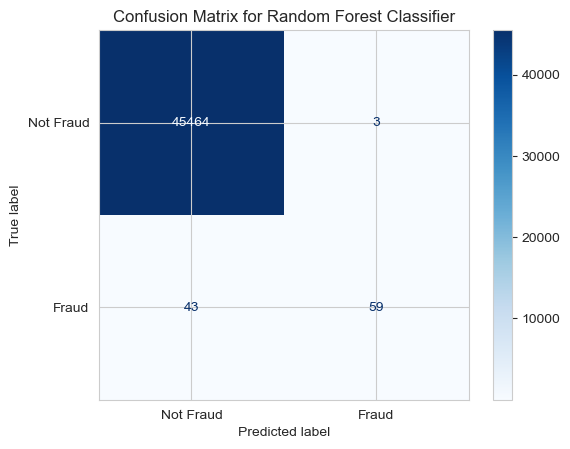

In [64]:
# Confusion Matrix and ROC AUC Score for Hard Voting
plot_confusion_matrix(valid_df[target].values, hard_preds, 'Voting Classifier using hard voting')

### Step 1: Initialize and train the Voting Classifier model using soft voting


In [65]:
voting_clf_soft = VotingClassifier(estimators=[
    ('logreg', best_model), 
    ('dt', dt_model), 
    ('rf', rf_model), 
    ('knn', knn_model), 
    ('nb', nb_model)
], voting='soft',
   verbose = 1)

In [66]:
# Train the models on the training set
voting_clf_soft.fit(train_df[predictors], train_df[target])


[Voting] ................... (1 of 5) Processing logreg, total=   4.5s
[Voting] ....................... (2 of 5) Processing dt, total=  47.5s
[Voting] ....................... (3 of 5) Processing rf, total= 8.8min
[Voting] ...................... (4 of 5) Processing knn, total=   0.1s
[Voting] ....................... (5 of 5) Processing nb, total=   0.2s


VotingClassifier(estimators=[('logreg',
                              LogisticRegression(C=0.1, penalty='l1',
                                                 solver='liblinear')),
                             ('dt', DecisionTreeClassifier(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('knn', KNeighborsClassifier()),
                             ('nb', GaussianNB())],
                 verbose=1, voting='soft')

### Step 2: Make predictions on the validation set


In [67]:
# Evaluate on the validation set
soft_preds = voting_clf_soft.predict(valid_df[predictors])

### Step 3: Evaluate the confusion matrix

Confusion Matrix:
[[45464     3]
 [   42    60]]


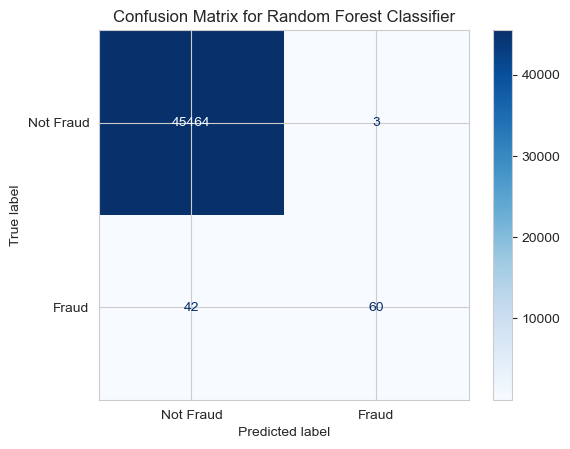

In [68]:
# Confusion Matrix and ROC AUC Score for Hard Voting
plot_confusion_matrix(valid_df[target].values, soft_preds, 'Voting classifier using soft voting')

### Step 4: Compute and display ROC AUC score

In [69]:
sv_roc_auc = roc_auc_score(valid_df[target], voting_clf_soft.predict_proba(valid_df[predictors])[:, 1]) 
print("\nROC AUC Score:", sv_roc_auc)


ROC AUC Score: 0.9798002602188961


### Step 5: Plot ROC Curve

ROC AUC Score: 0.98


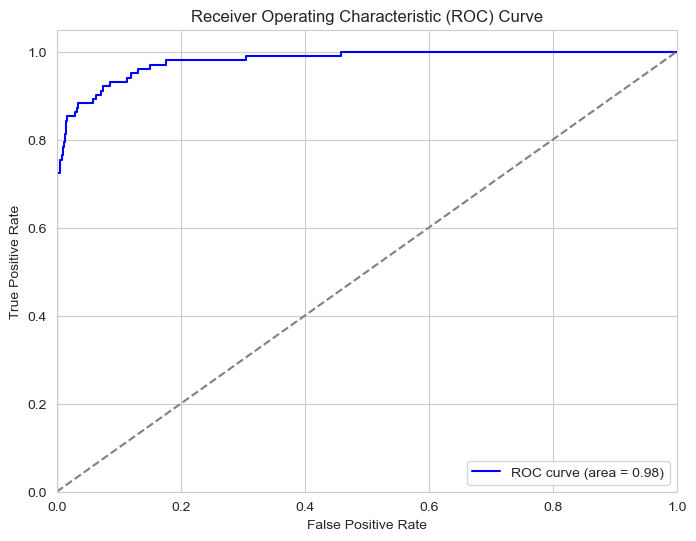

In [70]:
# Compute ROC AUC Score
roc_auc = roc_auc_score(valid_df[target].values, voting_clf_soft.predict_proba(valid_df[predictors])[:, 1])
print(f'ROC AUC Score: {roc_auc:.2f}')

# Optional: Plot ROC curve for visualization
fpr, tpr, thresholds = roc_curve(valid_df[target].values, voting_clf_soft.predict_proba(valid_df[predictors])[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Soft Voting Classifier Results

In our **Fraud Detection ML Project**, we combined multiple classifiers (Logistic Regression, Decision Trees, Random Forest, K-Nearest Neighbors, and Naive Bayes) using a **Soft Voting Classifier**. This method aggregates the predicted probabilities from each model to make a final prediction, leveraging the strengths of each individual classifier.

#### Results:
- **Confusion Matrix**:
  - True Positives (Fraud detected correctly): 60
  - True Negatives (Legitimate transactions detected correctly): 45,464
  - False Positives (Legitimate transactions misclassified as fraud): 3
  - False Negatives (Fraud transactions misclassified as legitimate): 42
- **ROC AUC Score**: 0.9798

#### Insights:
The Soft Voting Classifier demonstrated high performance with a strong ROC AUC score, indicating that the model is effectively distinguishing between fraudulent and legitimate transactions. The low false positive rate is particularly important in fraud detection, as it minimizes disruption for genuine customers.

Next, we will explore **Bagging techniques** to further improve the model's performance and stability.


## Bagging Classifier

C:\Users\91965\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning:

`base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  6.8min remaining: 20.5min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  7.9min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    1.5s remaining:    4.8s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.7s finished


Confusion Matrix:
[[45455    12]
 [   28    74]]


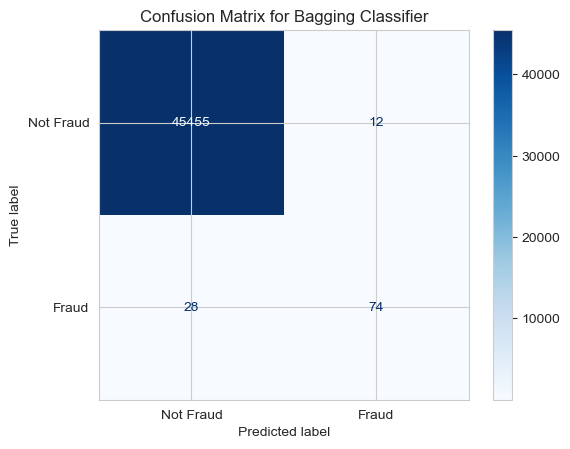

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.7s remaining:    2.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.9s finished



ROC AUC Score: 0.8961429470285924


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.7s remaining:    2.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.9s finished


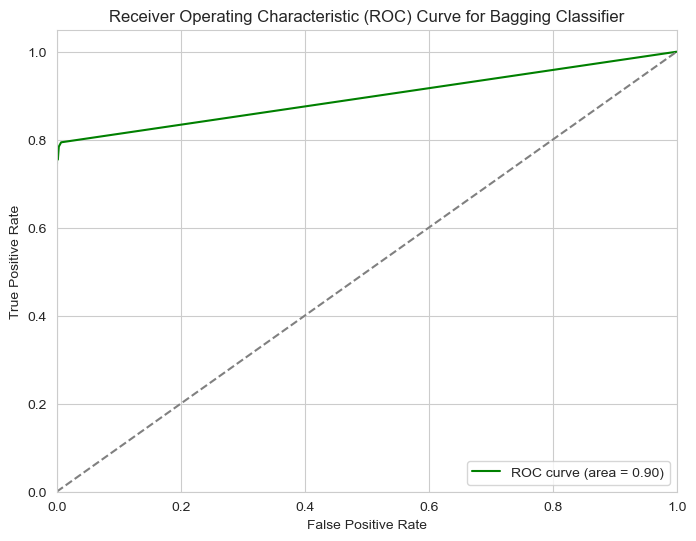

In [71]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Define the base estimator for bagging (e.g., Decision Tree)
base_estimator = DecisionTreeClassifier(random_state=42)

# Initialize the BaggingClassifier
bagging_clf = BaggingClassifier(
    base_estimator=base_estimator, # High-variance model suitable for bagging
    n_estimators=100,              # Number of trees in the ensemble
    max_samples=0.8,              # Percentage of data used in each bootstrap sample
    max_features=1.0,             # Percentage of features used in each bootstrap sample
    random_state=42,              # For reproducibility
    n_jobs=-1  ,                # Utilize all processors for parallel training
    verbose=1
)

# Train the BaggingClassifier
bagging_clf.fit(train_df[predictors], train_df[target])

# Evaluate on the validation set
bagging_preds = bagging_clf.predict(valid_df[predictors])

# Confusion Matrix
plot_confusion_matrix(valid_df[target].values, bagging_preds, 'Bagging Classifier')

# ROC AUC Score
bagging_roc_auc = roc_auc_score(valid_df[target], bagging_clf.predict_proba(valid_df[predictors])[:, 1])
print("\nROC AUC Score:", bagging_roc_auc)

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(valid_df[target], bagging_clf.predict_proba(valid_df[predictors])[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='green', label='ROC curve (area = %0.2f)' % bagging_roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Bagging Classifier')
plt.legend(loc="lower right")
plt.show()


## XGBOOST

#### XGBoost is a gradient boosting algorithm.

Let's prepare the model.

#### Prepare the model
We initialize the DMatrix objects for training and validation, starting from the datasets. We also set some of the parameters used for the model tuning.

In [73]:
# Prepare the train and valid datasets
dtrain = xgb.DMatrix(train_df[predictors], train_df[target].values)
dvalid = xgb.DMatrix(valid_df[predictors], valid_df[target].values)
dtest = xgb.DMatrix(test_df[predictors], test_df[target].values)

#What to monitor (in this case, **train** and **valid**)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Set xgboost parameters
params = {}
params['objective'] = 'binary:logistic'
params['eta'] = 0.039
params['silent'] = True
params['max_depth'] = 2
params['subsample'] = 0.8
params['colsample_bytree'] = 0.9
params['eval_metric'] = 'auc'
params['random_state'] = RANDOM_STATE

#### Train the model
Let's train the model.

In [74]:
model = xgb.train(params, 
                dtrain, 
                MAX_ROUNDS, 
                watchlist, 
                early_stopping_rounds=EARLY_STOP, 
                maximize=True, 
                verbose_eval=VERBOSE_EVAL)

C:\Users\91965\anaconda3\lib\site-packages\xgboost\core.py:723: FutureWarning:

Pass `evals` as keyword args.

C:\Users\91965\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning:

[13:21:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "silent" } are not used.




[0]	train-auc:0.94070	valid-auc:0.88632
[50]	train-auc:0.94061	valid-auc:0.89075
[100]	train-auc:0.97412	valid-auc:0.96356
[150]	train-auc:0.98566	valid-auc:0.98025
[200]	train-auc:0.99290	valid-auc:0.98470
[250]	train-auc:0.99495	valid-auc:0.98408
[263]	train-auc:0.99554	valid-auc:0.98342


#### The best validation score (ROC-AUC) was 0.984, for round 241.

#### Plot variable importance

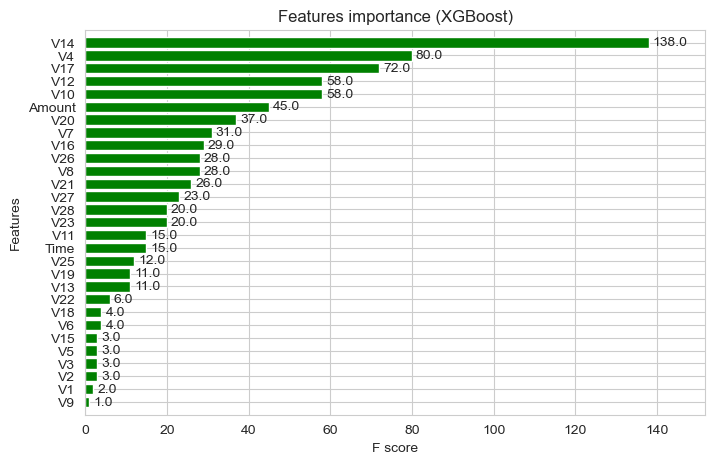

In [75]:
fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
xgb.plot_importance(model, height=0.8, title="Features importance (XGBoost)", ax=ax, color="green") 
plt.show()

#### Predict test set
We used the train and validation sets for training and validation. We will use the trained model now to predict the target value for the test set.

In [76]:
preds = model.predict(dtest)

#### Area under curve
Let's calculate ROC-AUC.

In [77]:
roc_auc_score(test_df[target].values, preds)

0.9794616791530372

#### The AUC score for the prediction of fresh data (test set) is 0.974

## LightGBM

#### Let's continue with another gradient boosting algorithm, LightGBM

#### Define model parameters
Let's set the parameters for the model. We will use these parameters only for the first lgb model

In [80]:
params = {
          'boosting_type': 'gbdt',
          'objective': 'binary',
          'metric':'auc',
          'learning_rate': 0.05,
          'num_leaves': 7,  # we should let it be smaller than 2^(max_depth)
          'max_depth': 4,  # -1 means no limit
          'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
          'max_bin': 100,  # Number of bucketed bin for feature values
          'subsample': 0.9,  # Subsample ratio of the training instance.
          'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
          'colsample_bytree': 0.7,  # Subsample ratio of columns when constructing each tree.
          'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
          'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
          'nthread': 8,
          'verbose': 0,
          'scale_pos_weight':150, # because training data is extremely unbalanced 
         }

#### Prepare the model¶
Let's prepare the model, creating the Datasets data structures from the train and validation sets

In [81]:
dtrain = lgb.Dataset(train_df[predictors].values, 
                     label=train_df[target].values,
                     feature_name=predictors)

dvalid = lgb.Dataset(valid_df[predictors].values,
                     label=valid_df[target].values,
                     feature_name=predictors)

#### Run the model

Let's run the model, using the train function.

In [82]:
evals_results = {}

model = lgb.train(params, 
                  dtrain, 
                  valid_sets=[dtrain, dvalid], 
                  valid_names=['train','valid'], 
                  evals_result=evals_results, 
                  num_boost_round=MAX_ROUNDS,
                  early_stopping_rounds=2*EARLY_STOP,
                  verbose_eval=VERBOSE_EVAL, 
                  feval=None)

C:\Users\91965\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

C:\Users\91965\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

C:\Users\91965\anaconda3\lib\site-packages\lightgbm\engine.py:260: UserWarning:

'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.103148 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 100 rounds
[50]	train's auc: 0.997909	valid's auc: 0.952288
[100]	train's auc: 0.999032	valid's auc: 0.945553
Early stopping, best iteration is:
[29]	train's auc: 0.996594	valid's auc: 0.957864


#### Best validation score was obtained for round 85, for which AUC ~= 0.974.

#### Let's plot variable importance.

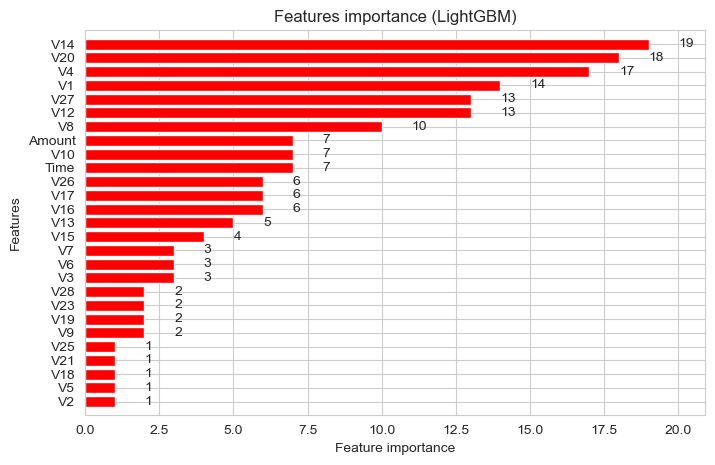

In [84]:
fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
lgb.plot_importance(model, height=0.8, title="Features importance (LightGBM)", ax=ax,color="red") 
plt.show()

#### Let's predict now the target for the test data.

#### Predict test data

In [85]:
preds = model.predict(test_df[predictors])

#### Area under curve
Let's calculate the ROC-AUC score for the prediction.

In [86]:
roc_auc_score(test_df[target].values, preds)

0.9473337202349548

#### The ROC-AUC score obtained for the test set is 0.946.

#### Training and validation using cross-validation
Let's use now cross-validation. We will use cross-validation (KFolds) with 5 folds. Data is divided in 5 folds and, by rotation, we are training using 4 folds (n-1) and validate using the 5th (nth) fold.

Test set is calculated as an average of the predictions

In [88]:
kf = KFold(n_splits = NUMBER_KFOLDS, random_state = RANDOM_STATE, shuffle = True)

# Create arrays and dataframes to store results
oof_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
feature_importance_df = pd.DataFrame()
n_fold = 0
for train_idx, valid_idx in kf.split(train_df):
    train_x, train_y = train_df[predictors].iloc[train_idx],train_df[target].iloc[train_idx]
    valid_x, valid_y = train_df[predictors].iloc[valid_idx],train_df[target].iloc[valid_idx]
    
    evals_results = {}
    model =  LGBMClassifier(
                  nthread=-1,
                  n_estimators=2000,
                  learning_rate=0.01,
                  num_leaves=80,
                  colsample_bytree=0.98,
                  subsample=0.78,
                  reg_alpha=0.04,
                  reg_lambda=0.073,
                  subsample_for_bin=50,
                  boosting_type='gbdt',
                  is_unbalance=False,
                  min_split_gain=0.025,
                  min_child_weight=40,
                  min_child_samples=510,
                  objective='binary',
                  metric='auc',
                  silent=-1,
                  verbose=-1,
                  feval=None)
    model.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
                eval_metric= 'auc', verbose= VERBOSE_EVAL, early_stopping_rounds= EARLY_STOP)
    
    oof_preds[valid_idx] = model.predict_proba(valid_x, num_iteration=model.best_iteration_)[:, 1]
    test_preds += model.predict_proba(test_df[predictors], num_iteration=model.best_iteration_)[:, 1] / kf.n_splits
    
    
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
    del model, train_x, train_y, valid_x, valid_y
    gc.collect()
    n_fold = n_fold + 1
train_auc_score = roc_auc_score(train_df[target], oof_preds)
print('Full AUC score %.6f' % train_auc_score)

C:\Users\91965\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning:

'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.

C:\Users\91965\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

C:\Users\91965\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=-1 will be ignored. Current value: num_threads=-1
[50]	training's auc: 0.972313	valid_1's auc: 0.990201
[100]	training's auc: 0.97139	valid_1's auc: 0.992925
[150]	training's auc: 0.974237	valid_1's auc: 0.997586
[200]	training's auc: 0.974713	valid_1's auc: 0.997987
[250]	training's auc: 0.975847	valid_1's auc: 0.998143
Fold  1 AUC : 0.998184


C:\Users\91965\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning:

'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.

C:\Users\91965\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

C:\Users\91965\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=-1 will be ignored. Current value: num_threads=-1
[50]	training's auc: 0.979082	valid_1's auc: 0.963933
Fold  2 AUC : 0.966302


C:\Users\91965\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning:

'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.

C:\Users\91965\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

C:\Users\91965\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=-1 will be ignored. Current value: num_threads=-1
[50]	training's auc: 0.980517	valid_1's auc: 0.937209
[100]	training's auc: 0.981387	valid_1's auc: 0.938327
[150]	training's auc: 0.981624	valid_1's auc: 0.939771
[200]	training's auc: 0.981827	valid_1's auc: 0.942898
[250]	training's auc: 0.983151	valid_1's auc: 0.942886
Fold  3 AUC : 0.943196


C:\Users\91965\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning:

'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.

C:\Users\91965\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

C:\Users\91965\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=-1 will be ignored. Current value: num_threads=-1
[50]	training's auc: 0.969943	valid_1's auc: 0.988765
[100]	training's auc: 0.97331	valid_1's auc: 0.992088
Fold  4 AUC : 0.993275


C:\Users\91965\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning:

'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.

C:\Users\91965\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

C:\Users\91965\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=-1 will be ignored. Current value: num_threads=-1
[50]	training's auc: 0.962251	valid_1's auc: 0.976423
[100]	training's auc: 0.971749	valid_1's auc: 0.984237
[150]	training's auc: 0.972767	valid_1's auc: 0.983043
Fold  5 AUC : 0.984831
Full AUC score 0.970312


#### The AUC score for the prediction from the test data was 0.97

#### We prepare the test prediction, from the averaged predictions for test over the 5 folds.

In [89]:
pred = test_preds

# Conclusion

## Data Exploration and Model Evaluation

**1. Data Exploration**

* **Data Unbalancing:** Investigated and addressed any class imbalances within the dataset.
* **Feature Visualization:** Visualized key features to understand their distributions and potential relationships.
* **Feature Relationships:** Analyzed the relationships between different features to identify potential correlations and dependencies.

**2. Model Evaluation**

* **Data Split:** Split the data into three sets:
    * **Train Set:** Used for model training.
    * **Validation Set:** Used for hyperparameter tuning and model selection (for XGBoost).
    * **Test Set:** Used for final model evaluation.

* **Models Evaluated:**

    * **Logistic Regression:**
        * AUC Score on Test Set: 0.98
    * **Decision Tree Classifier:**
        * AUC Score on Test Set: 0.83
    * **Random Forest Classifier:**
        * AUC Score on Test Set: 0.92
    * **Naive Bayes Classifier:**
        * AUC Score on Test Set: 0.96
    * **XGBoost:**
        * Best Validation Score: 0.984
        * AUC Score on Test Set: 0.974
    * **LightGBM:**
        * Train-Validation Split:
            * Validation Set AUC: ~0.974
            * Test Set AUC: 0.946
        * Cross-Validation:
            * Test Set AUC: 0.97

**3. Model Selection**

Based on the evaluation results, the **XGBoost** and **Naive Bayes** models demonstrated strong performance with high AUC scores on the test set. Further analysis and consideration of factors like model interpretability, computational cost, and specific business requirements will guide the final model selection.

**Note:**

* This is a basic framework. You can further enhance it by adding details about specific data preprocessing steps, hyperparameter tuning methods, and any challenges encountered during the analysis.
* Consider adding visualizations and tables to enhance the report's clarity and impact.
